## Advanced models - Masked lungs multiclasses
This notebook is training and testing our final model using masked lung images and for classifying 4 classes `['COVID','NORMAL','Viral Pneumonia','Lung_Opacity']`.

For this notebook to find the new modules created for this project, we need to set its path to be in the root directory.

In [1]:
# Auto reload modules
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
sys.path.append("../")

## Loading packages and dependencies

In [ ]:
from src.preprocessing.image_augmentor import load_dataset_images
from src.models.build_model import train_advanced_supervised_model, evaluate_model
from src.visualization.visualize import show_grad_cam_cnn, get_predication_output,show_loss_accuracy_report, show_confusion_matrix_report

# Path to the raw data and preprocessed data
raw_data_dir ='../data/raw/dataset/masked_images_dataset'
store_images_dir = '../reports/images/grad_cam'
IMG_SIZE = 256  # Resize images to IMG_SIZExIMG_SIZE pixels
batch_size = 16

## Extracting features from images

In [ ]:
train_data, val_data, class_weight_dict = load_dataset_images(raw_data_dir, (IMG_SIZE, IMG_SIZE), batch_size)

Found 32612 files belonging to 4 classes.


2025-04-21 15:43:20.167100: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-04-21 15:43:20.167134: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 128.00 GB
2025-04-21 15:43:20.167138: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 48.00 GB
2025-04-21 15:43:20.167157: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-21 15:43:20.167168: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 8156 files belonging to 4 classes.
Computed Class Weights:{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0} labels: ['COVID', 'Lung_Opacity', 'NORMAL', 'Viral Pneumonia']


Check if there is an overlap between training and validation datasets.

In [ ]:
train_file_paths = train_data.file_paths
val_file_paths = val_data.file_paths

# Now, check if there is any intersection (common files)
overlap = set(train_file_paths).intersection(set(val_file_paths))

# Print results
if overlap:
    print(f"⚠️ Overlap found! {len(overlap)} overlapping files.")
    for file in list(overlap)[:5]:  # print first 5 overlaps
        print(file)
else:
    print("✅ No overlap between training and validation datasets.")

✅ No overlap between training and validation datasets.


## Training and evaluating models

### Convolutional Neural Networks (CNN)

✅ Strengths:
* Highly accurate for image tasks.
* Learns complex patterns automatically.
* Works well with large image datasets.

❌ Weaknesses:
* Computationally expensive (needs GPUs).
* Requires large labeled datasets.
* Not easily interpretable.

In [ ]:
# Train the model
cnn_model, cnn_history = train_advanced_supervised_model(train_data, val_data, IMG_SIZE, 300, 4, None, 
                                                         filter_layers=[32, 64, 128, 256, 512], conv2d_layers=4, dense_layers=[128, 32], 
                                                         attention=True, aspp=True, model_type='CNN', classification_type='categorical')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing (Resizing) │ (None, 128, 128,  │          0 │ rescaling[0][0]   │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        320 │ resizing[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_5[0][0]  

 Total params: 13,021,004 (49.67 MB)

 Trainable params: 13,013,068 (49.64 MB)

 Non-trainable params: 7,936 (31.00 KB)

Epoch 1/300


2025-04-21 15:43:40.362663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2039/2039 ━━━━━━━━━━━━━━━━━━━━ 425s 203ms/step - accuracy: 0.4909 - loss: 0.2478 - val_accuracy: 0.5310 - val_loss: 0.5540 - learning_rate: 1.0000e-04
Epoch 2/300
2039/2039 ━━━━━━━━━━━━━━━━━━━━ 420s 206ms/step - accuracy: 0.6101 - loss: 0.4667 - val_accuracy: 0.6204 - val_loss: 0.1815 - learning_rate: 1.0000e-04
Epoch 3/300
2039/2039 ━━━━━━━━━━━━━━━━━━━━ 422s 207ms/step - accuracy: 0.6194 - loss: 0.4933 - val_accuracy: 0.6545 - val_loss: 0.3411 - learning_rate: 1.0000e-04
Epoch 4/300
2039/2039 ━━━━━━━━━━━━━━━━━━━━ 420s 206ms/step - accuracy: 0.6377 - loss: 0.5657 - val_accuracy: 0.7292 - val_loss: 0.5422 - learning_rate: 1.0000e-04
Epoch 5/300
2039/2039 ━━━━━━━━━━━━━━━━━━━━ 420s 206ms/step - accuracy: 0.6695 - loss: 0.5145 - val_accuracy: 0.7181 - val_loss: 0.2912 - learning_rate: 1.0000e-04
Epoch 6/300
2039/2039 ━━━━━━━━━━━━━━━━━━━━ 416s 204ms/step - accuracy: 0.6872 - loss: 0.4187 - val_accuracy: 0.7310 - val_loss: 0.6966 - learning_rate: 1.0000e-04
Epoch 7/300
2039/2039 ━━━━━━━━━━━━

In [ ]:
cnn_train_loss, cnn_train_acc = cnn_history.history['loss'][-1], cnn_history.history['accuracy'][-1]
print(f"Train Accuracy: {cnn_train_acc:.4f}, Train Loss: {cnn_train_loss:.4f}")

cnn_test_loss, cnn_test_acc = evaluate_model("Multi-label classification [Normal, COVID, Viral Pneumonia, Lung_Opacity] for masked images", 
                                             cnn_model, val_data, _, balanced=True, model_type="CNN", 
                                             classification_type="multiclass", history=cnn_history)
print(f"Test Accuracy: {cnn_test_acc:.4f}, Test Loss: {cnn_test_loss:.4f}")

Train Accuracy: 0.9512, Train Loss: 0.0093
510/510 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.8819 - loss: 0.0326
510/510 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step


2025-04-22 01:26:49.412230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-22 01:26:50.027784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


255/255 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step


2025/04/22 01:27:32 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/8n/nbmb1plx3ds3tkyfrf566z2r0000gn/T/tmpal_k9u0n/model, flavor: tensorflow). Fall back to return ['tensorflow==2.16.2', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
Registered model 'tensorflow-CNN-multiclass' already exists. Creating a new version of this model...
2025/04/22 01:27:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: tensorflow-CNN-multiclass, version 10


🏃 View run CNN-multiclass at: http://localhost:8080/#/experiments/153317371393485179/runs/3c813767d1fa46b08f8686de39ffcd77
🧪 View experiment at: http://localhost:8080/#/experiments/153317371393485179
Test Accuracy: 0.9193, Test Loss: 0.0221


Created version '10' of model 'tensorflow-CNN-multiclass'.


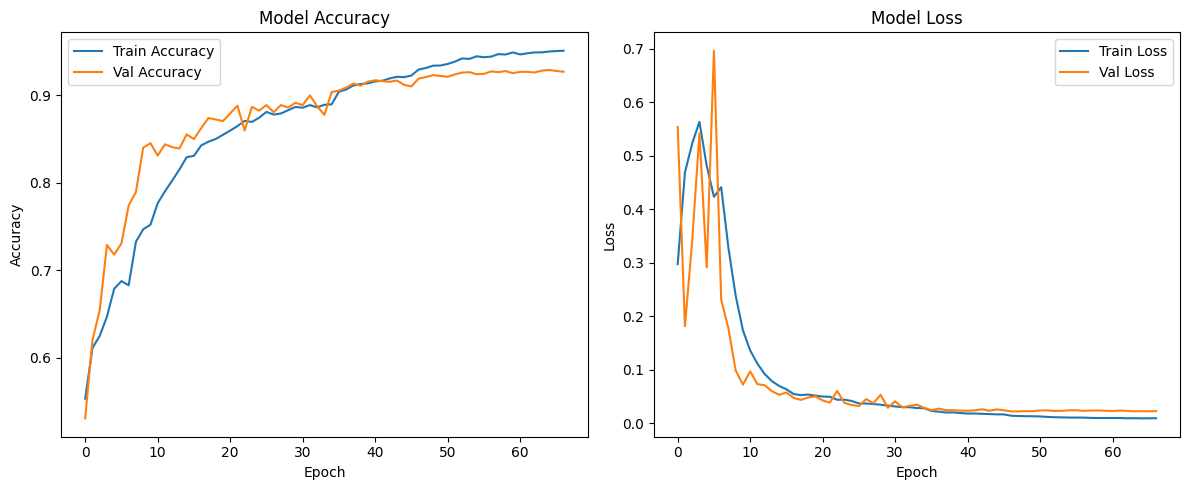

In [8]:
show_loss_accuracy_report(cnn_history)

510/510 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step
                 precision    recall  f1-score   support

          COVID       0.93      0.86      0.89      2039
   Lung_Opacity       0.85      0.88      0.87      2039
         NORMAL       0.91      0.93      0.92      2039
Viral Pneumonia       0.99      1.00      0.99      2039

       accuracy                           0.92      8156
      macro avg       0.92      0.92      0.92      8156
   weighted avg       0.92      0.92      0.92      8156



2025-04-22 09:49:50.165333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


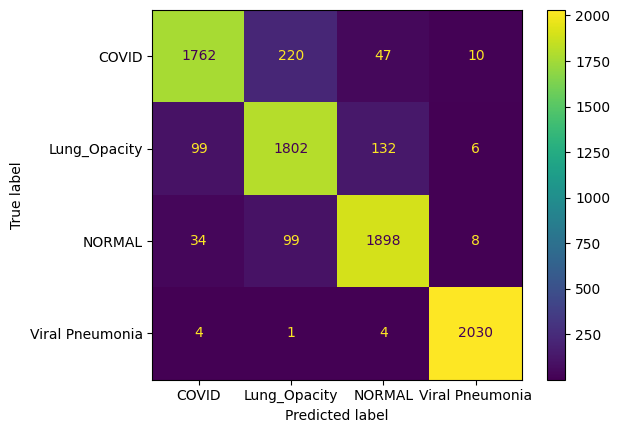

In [41]:
show_confusion_matrix_report(cnn_model, val_data)

In [12]:
val_iter = iter(val_data)
class_names = val_data.class_names
images, labels =next(val_iter)

Model interpretation with GradCam for random validation images is saved to `reports/images/grad_cam`.

In [13]:
show_grad_cam_cnn(images[:4], cnn_model, class_names, labels, save_dir=store_images_dir, image_name="3.5_cnn", save_image=True)

Show prediction results for random images.

In [14]:
display(get_predication_output(images[:100], cnn_model, class_names, labels).head(100))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


,image,confidence,predicted_class,actual_class
0,0,99.194688,COVID,COVID
1,1,59.687597,NORMAL,COVID
2,2,79.809672,COVID,COVID
3,3,76.717001,Lung_Opacity,COVID
4,4,60.790265,Lung_Opacity,COVID
5,5,62.621182,COVID,COVID
6,6,89.920223,COVID,COVID
7,7,50.569224,COVID,COVID
8,8,51.213354,Lung_Opacity,COVID
9,9,77.405298,COVID,COVID
